# Database Connection - Linear Regression

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model and evaluate results

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:
$   pip install psycopg2
$   pip install psycopg2-binary 

In [1]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.datasets as datasets

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [2]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [3]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# List tables in database
inspect(engine).get_table_names()

['high_low_poverty',
 'ave_wage_indexing',
 'welfare_education',
 'economic_features_full',
 'economic_features',
 'lowest_poverty_rates',
 'highest_poverty_rates',
 'cpi_inflation_rate',
 'crime_rate',
 'divorce_rate',
 'homeownership_rate',
 'min_wage_effective',
 'poverty_rates',
 'unemployment_rate']

In [6]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [7]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [8]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

,year,state,population_million,education_million,welfare_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate
0,1970,National,203.302,56456.0,18738.8,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18
1,1971,National,205.515,63469.0,27364.3,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05
2,1972,National,207.752,71351.0,30594.3,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12
3,1973,National,210.013,75849.0,28944.9,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13
4,1974,National,212.299,81440.0,34816.4,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86


## Additional data processing

In [9]:
# Calculate additional features

econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']


In [10]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.head()

,year,state,population_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
0,1970,National,203.302,363.5,NaN,3.50,NaN,1.382353,38.8,5.8,6186.24,17.18,277.695251,92.172236
1,1971,National,205.515,396.0,NaN,3.75,NaN,1.382353,40.5,4.3,6497.08,17.05,308.829039,133.149892
2,1972,National,207.752,401.0,NaN,4.00,NaN,1.623529,41.8,3.3,7133.80,16.12,343.443144,147.263564
3,1973,National,210.013,417.4,NaN,4.25,NaN,1.623529,44.4,6.2,7580.16,15.13,361.163357,137.824325
4,1974,National,212.299,461.1,NaN,4.50,NaN,1.623529,49.3,11.1,8030.76,15.86,383.609909,163.997004


## Model for 1 state

In [11]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Michigan', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'New Jersey', 'Nevada', 'New Hampshire', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [12]:
# Pick data for 1 state
state_to_model = 'Texas'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df

,population_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita
year,,,,,,,,,,,,
1984,15.274,505.0,6.1,4.9778,62.5,3.35,103.900,4.3,16135.07,22.4,841.894723,201.839728
1985,15.547,550.0,7.0,4.9222,60.5,3.35,107.600,3.5,16822.51,22.4,915.642889,205.628095
1986,15.825,658.9,8.8,4.8667,61.0,3.35,109.600,1.9,17321.82,22.6,986.350711,224.000000
1987,16.108,631.1,8.5,4.8111,61.1,3.35,113.600,3.7,18426.51,22.7,988.999255,272.547802
1988,16.395,652.6,7.4,4.7556,59.9,3.35,118.300,4.1,19334.04,22.3,1021.018603,264.812443
1989,16.688,658.5,6.7,4.7000,61.0,3.35,124.000,4.8,20099.55,21.8,1079.290508,271.919942
1990,16.987,761.4,6.4,4.7000,59.7,3.35,130.700,5.4,21027.98,21.6,1150.774121,323.541532
1991,17.338,840.1,7.0,4.6429,59.0,3.80,136.200,4.2,21811.60,21.4,1158.507325,392.617372
1992,17.698,806.3,7.7,4.5857,58.3,4.25,140.300,3.0,22935.42,21.1,1248.067578,257.447169


In [13]:
# Define X and y variables
X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = model_state_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

X shape: (31, 11)


,population_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,education_per_capita,welfare_per_capita
year,,,,,,,,,,,
1984,15.274,505.0,6.1,4.9778,62.5,3.35,103.9,4.3,16135.07,841.894723,201.839728
1985,15.547,550.0,7.0,4.9222,60.5,3.35,107.6,3.5,16822.51,915.642889,205.628095
1986,15.825,658.9,8.8,4.8667,61.0,3.35,109.6,1.9,17321.82,986.350711,224.000000
1987,16.108,631.1,8.5,4.8111,61.1,3.35,113.6,3.7,18426.51,988.999255,272.547802
1988,16.395,652.6,7.4,4.7556,59.9,3.35,118.3,4.1,19334.04,1021.018603,264.812443


In [14]:
model_state_df.dtypes

population_million              float64
crime_rate                      float64
unemployment_rate               float64
divorce_rate_per_1000_people    float64
homeownership_rate              float64
minimum_wage_effective          float64
cpi_average                     float64
inflation_rate                  float64
avg_wage_index                  float64
poverty_rate                    float64
education_per_capita            float64
welfare_per_capita              float64
dtype: object

In [82]:
#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

In [15]:
# Create a model with scikit-learn
model = LinearRegression()

In [16]:
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

LinearRegression()

In [84]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [85]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)


(36,)
(36, 11)


In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y,y_pred)}')
print(f'Mean square error: {mean_squared_error(y,y_pred)}')
print(f'r2 score: {r2_score(y,y_pred)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean absolute error: 0.24186149157461895
Mean square error: 0.10248079818647203
r2 score: 0.9266700840428257
Coefficients: [ 5.29514430e-02 -3.45170747e-03  1.02115383e+00  3.12147184e+00
 -4.77057926e-01 -9.93025707e-01  6.82874907e-02  2.76638880e-01
 -2.47030826e-04  3.53862834e-03 -3.78324110e-03]
Intercept: 11.361216335952003


In [87]:
model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

,population_million,crime_rate,unemployment_rate,divorce_rate_per_1000_people,homeownership_rate,minimum_wage_effective,cpi_average,inflation_rate,avg_wage_index,poverty_rate,education_per_capita,welfare_per_capita,predicted_poverty
year,,,,,,,,,,,,,
1984,235.164,539.2,7.637412,4.9778,64.5,3.360196,103.9,4.3,16135.07,16.04,816.132571,611.113521,16.057125
1985,237.369,556.6,7.304109,4.9222,63.9,3.360196,107.6,3.5,16822.51,15.72,881.441974,696.980650,15.653934
1986,239.595,620.1,7.096872,4.8667,63.8,3.360196,109.6,1.9,17321.82,15.20,950.374590,663.830213,15.155414
1987,241.842,609.7,6.297189,4.8111,64.0,3.360196,113.6,3.7,18426.51,14.48,1003.522961,691.828549,14.805084
1988,244.110,637.2,5.589161,4.7556,63.8,3.409804,118.3,4.1,19334.04,14.81,1065.191922,724.515997,14.282137


<AxesSubplot:title={'center':'National'}, xlabel='year'>

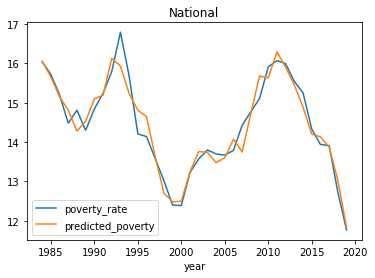

In [88]:
# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
plt.plot(X, y_pred, color='red')
#plt.show()

In [59]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-8.19432789e-01 -7.47694436e-02  2.32125315e-05 -1.51410363e-05
  4.12829603e-03  1.07730287e+00 -2.32657306e+00 -1.68965782e-01
 -8.37761955e-01  7.81550727e-02  2.48173477e-04]
1649.9479309010358


## Create Function

In [17]:
def run_model(df, state='National', model_type='linear'):
    m_df = df.loc[df['state']==state].dropna().set_index('year')
    m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
    X = m_df.drop(["poverty_rate"], axis=1)
    y = m_df["poverty_rate"]

    # Create a model with scikit-learn
    if model_type=='linear':
        model = LinearRegression()
    elif model_type =='ridge':
        model = Ridge(alpha=0.5)
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
    else:
        model = LinearRegression()
        
    # Fit the data into the model
    model.fit(X, y)
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
    
    y_pred = model.predict(X)
    m_df['predicted_poverty'] = y_pred
    m_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=f'{state}:{model_type}')
    
    results = { 'State': state,
                'Model': model_type,
                'Mean absolute error': mean_absolute_error(y,y_pred),
                'Mean square error': mean_squared_error(y,y_pred),
                'r2 score': r2_score(y,y_pred),
                'Coefficients': model.coef_,
                'Intercept': model.intercept_
              }
    return results
    

C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


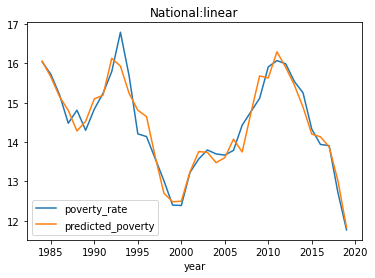

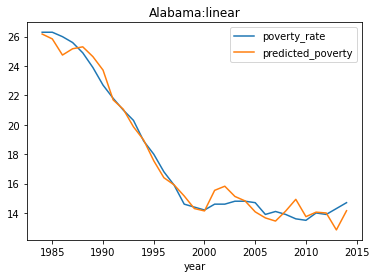

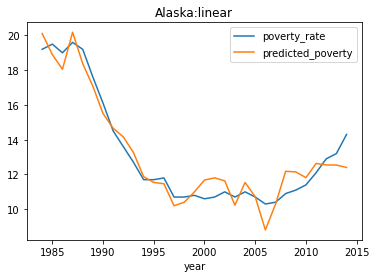

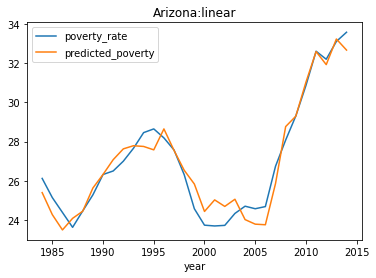

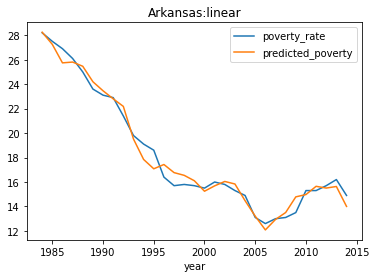

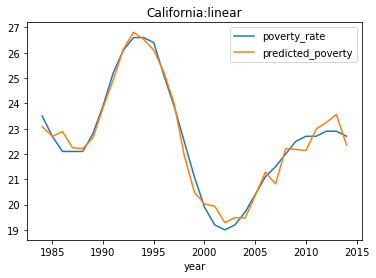

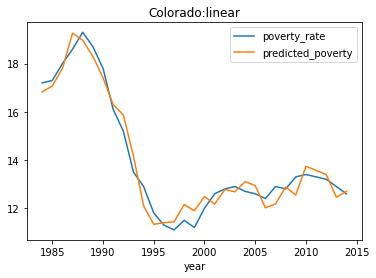

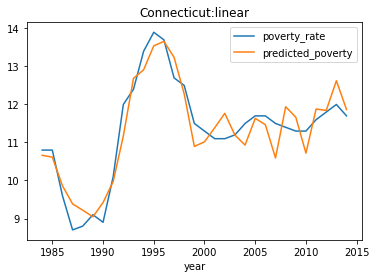

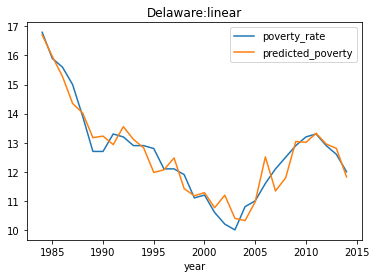

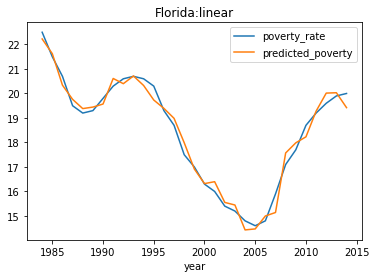

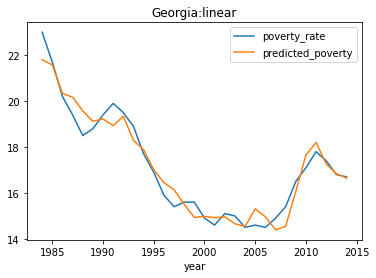

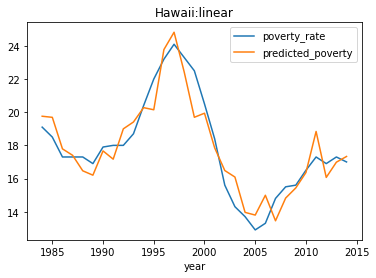

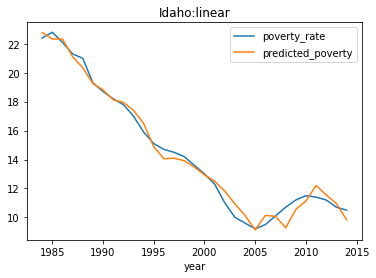

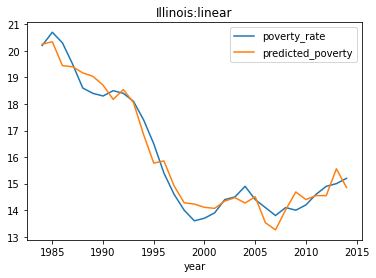

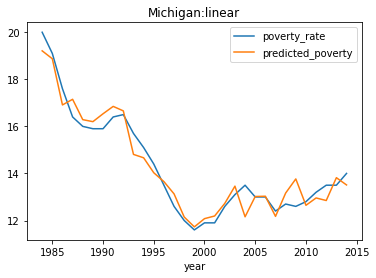

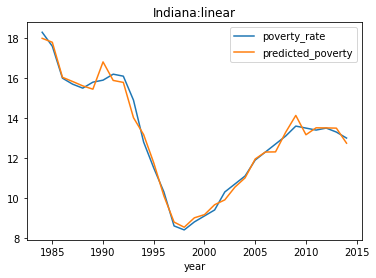

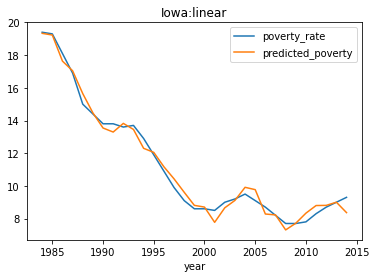

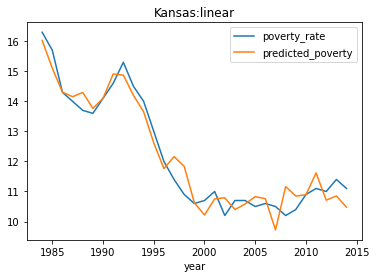

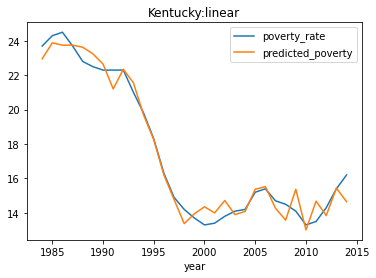

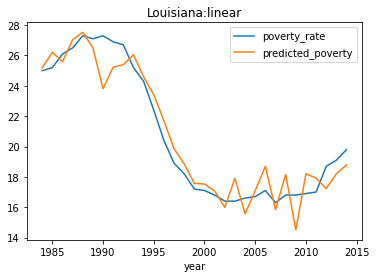

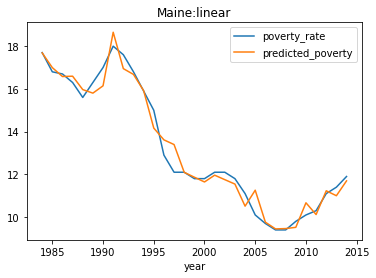

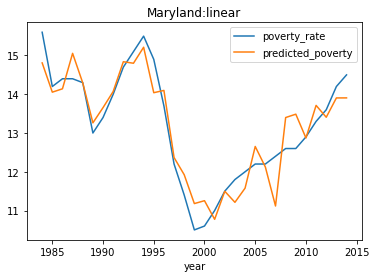

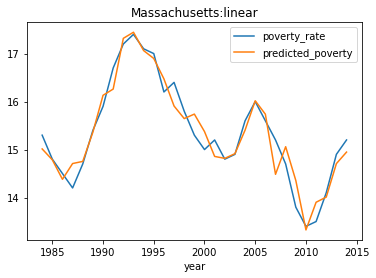

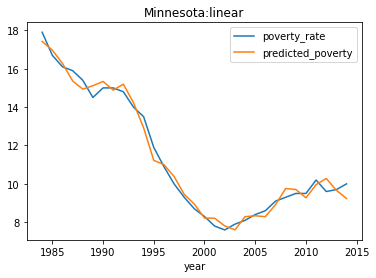

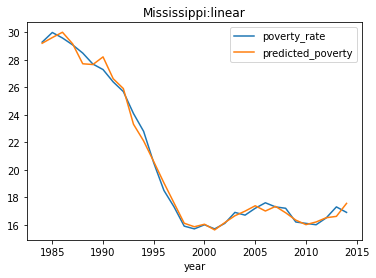

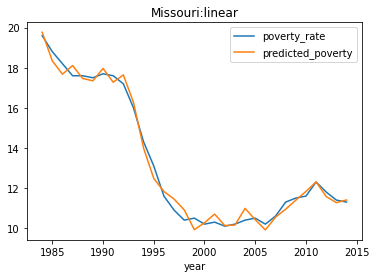

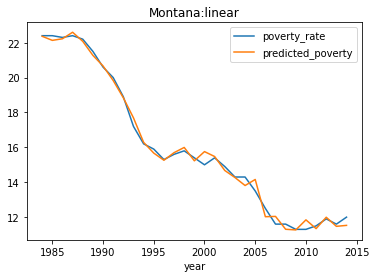

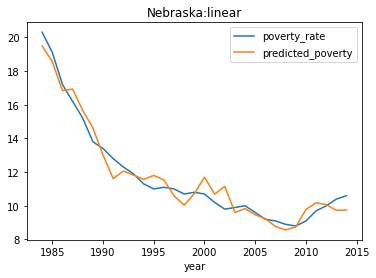

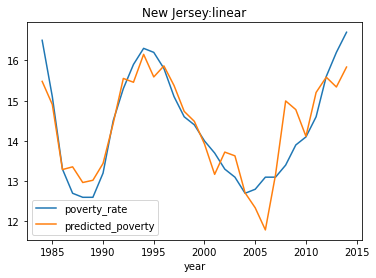

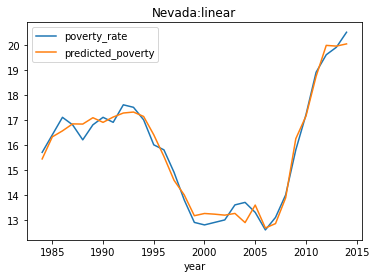

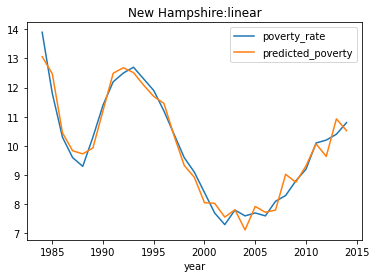

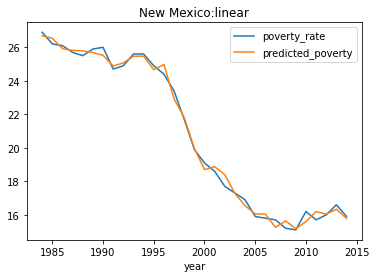

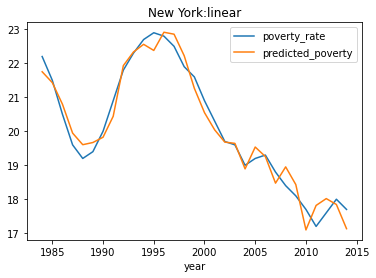

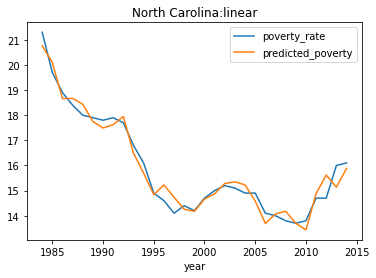

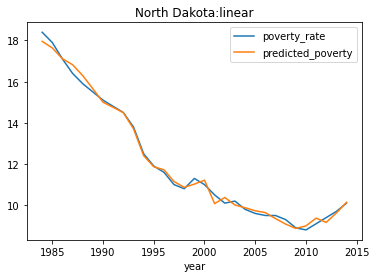

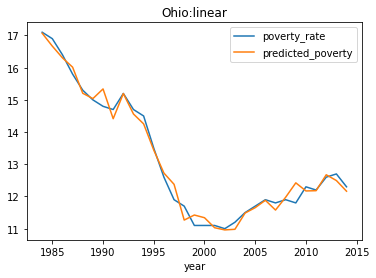

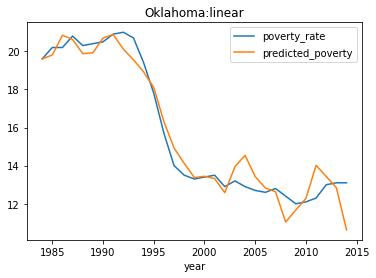

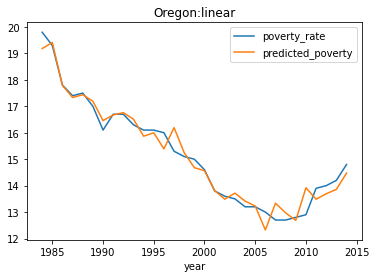

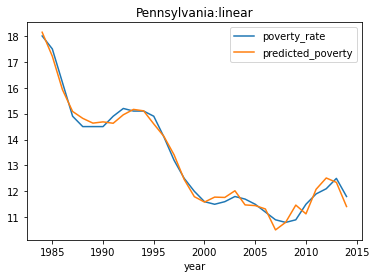

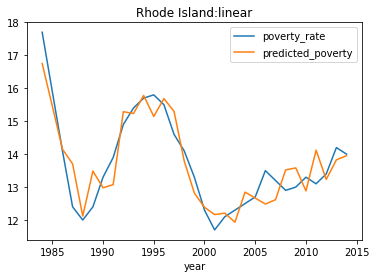

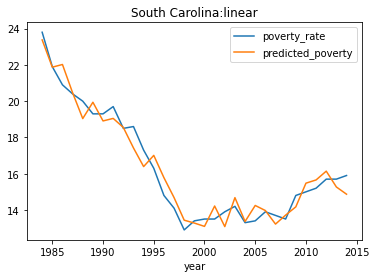

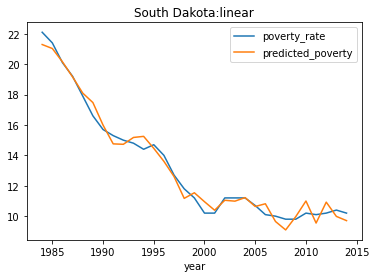

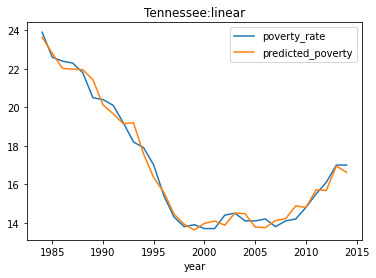

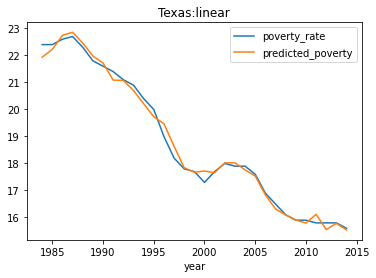

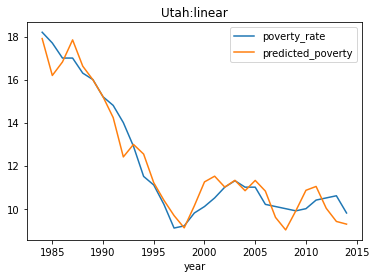

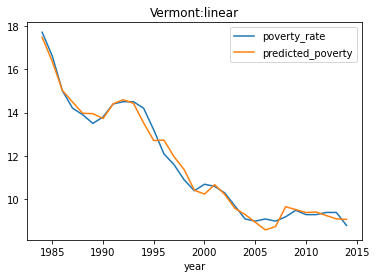

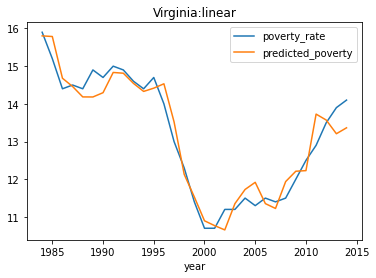

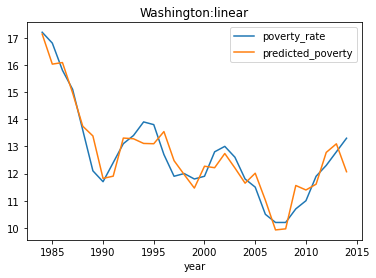

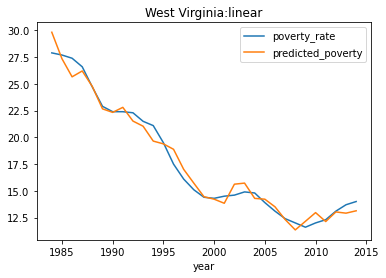

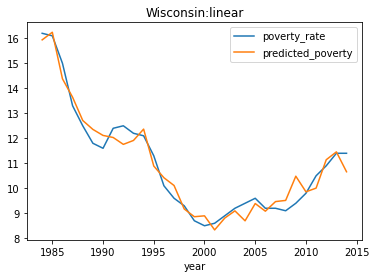

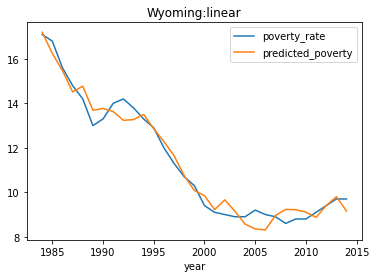

In [103]:
result_df = pd.DataFrame()
for state in model_df.state.unique():
    result = run_model(model_df, state, 'linear')
    result_df = result_df.append(result, ignore_index=True)


C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


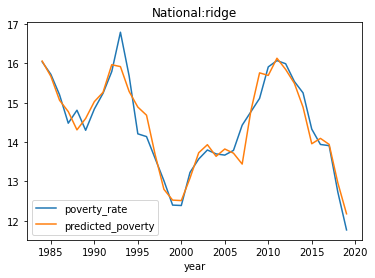

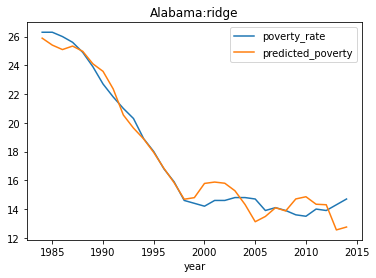

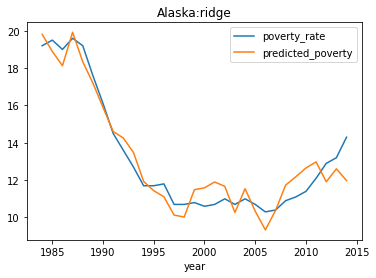

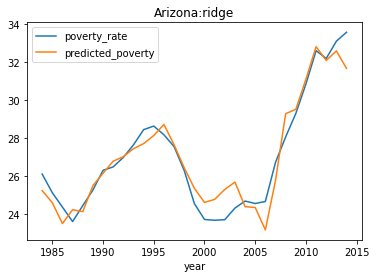

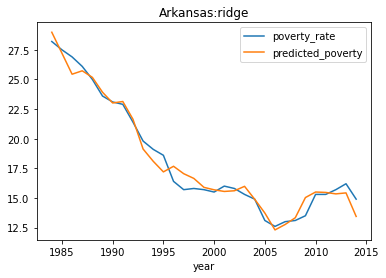

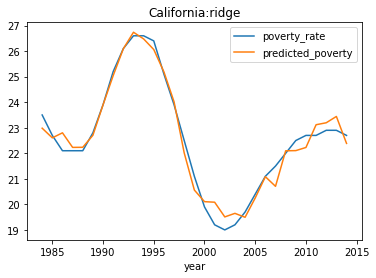

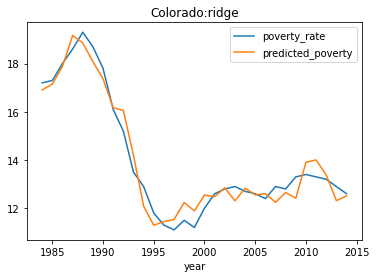

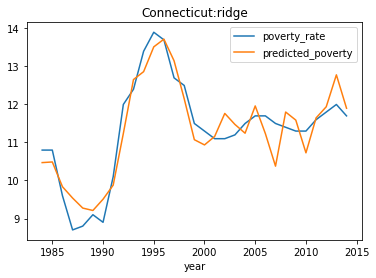

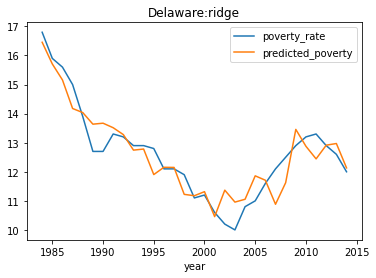

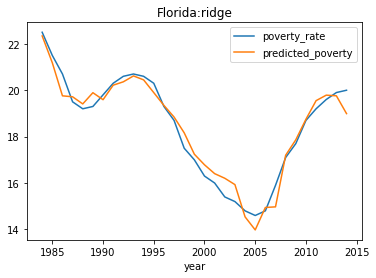

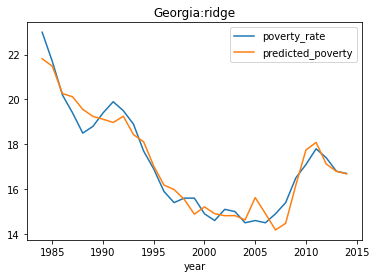

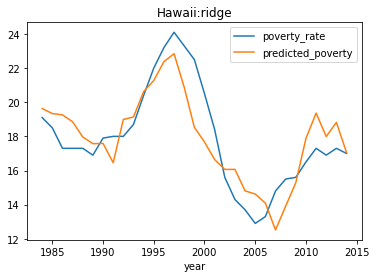

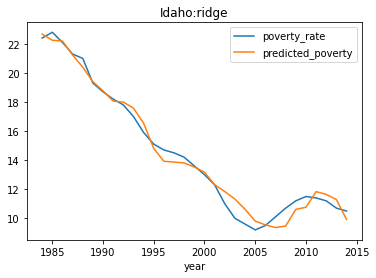

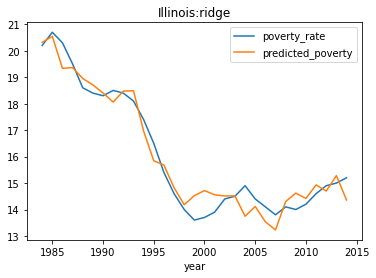

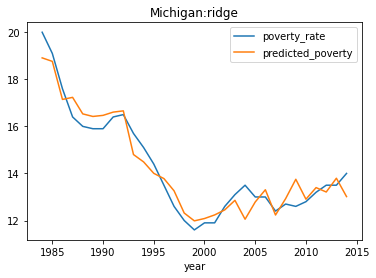

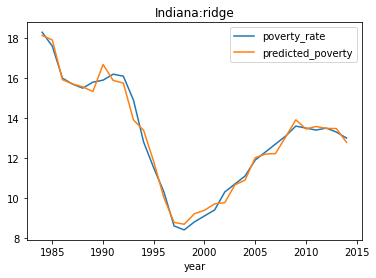

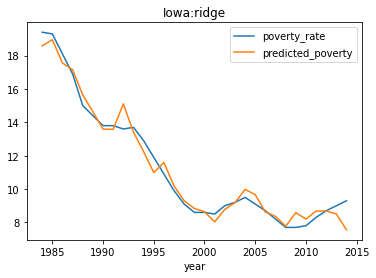

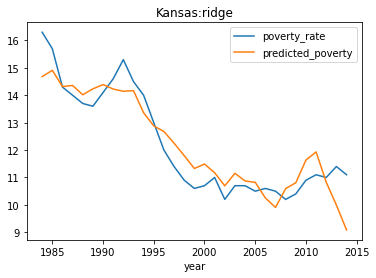

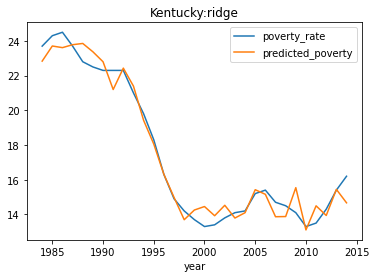

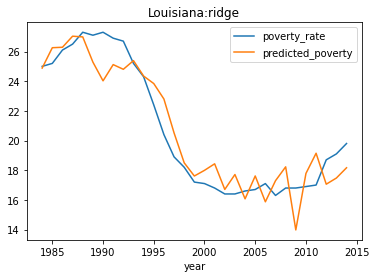

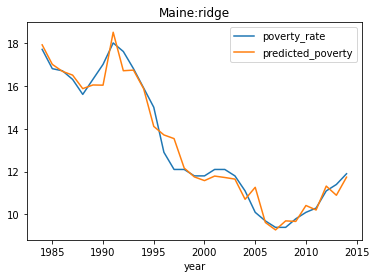

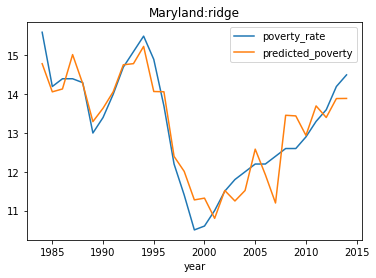

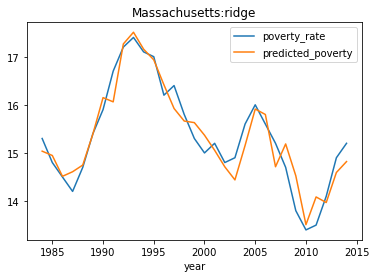

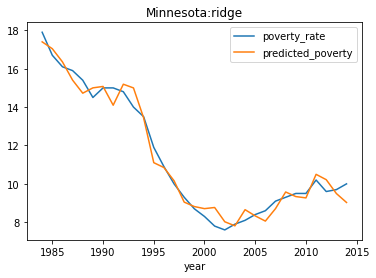

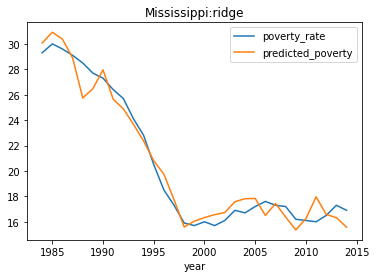

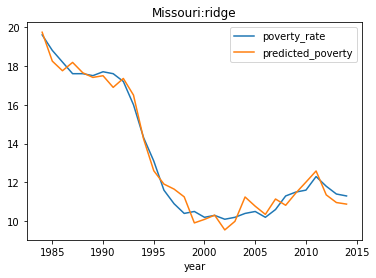

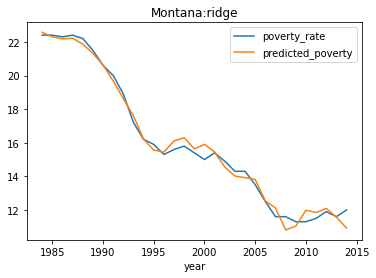

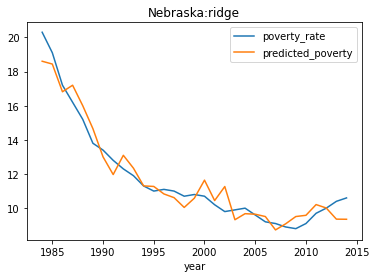

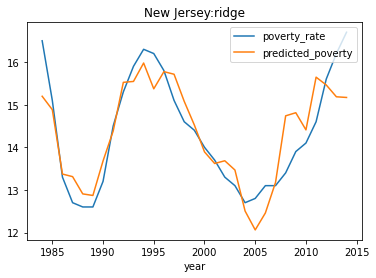

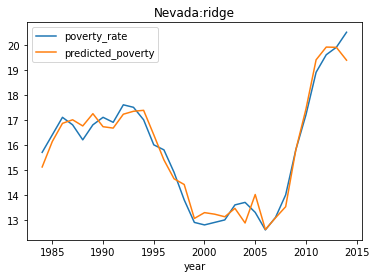

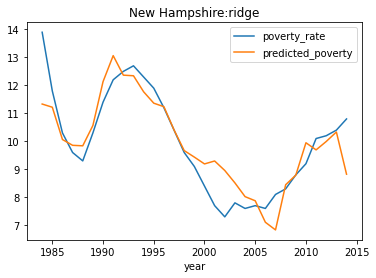

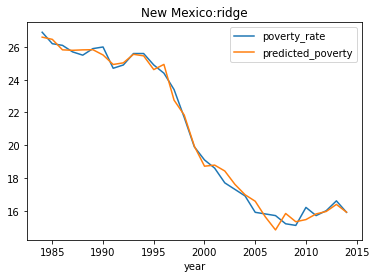

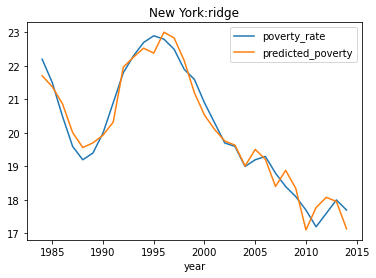

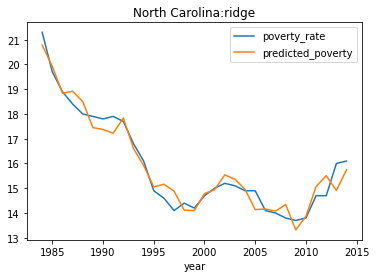

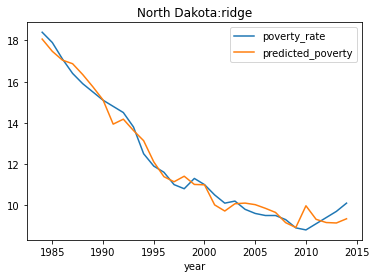

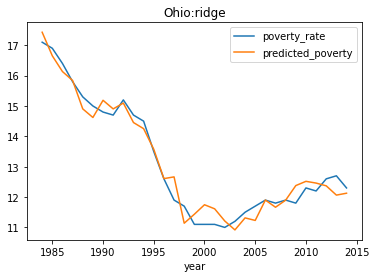

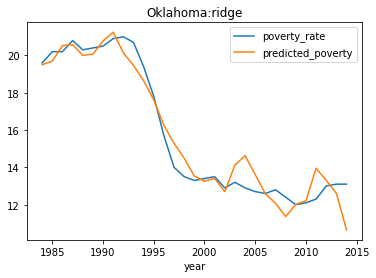

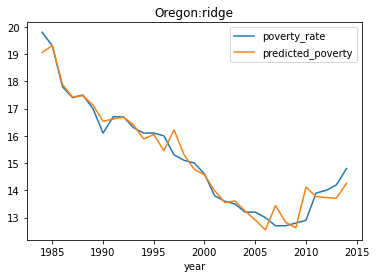

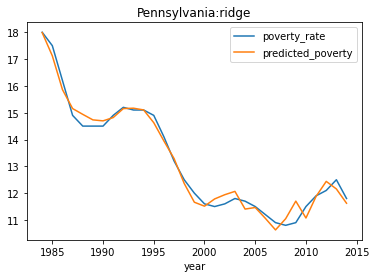

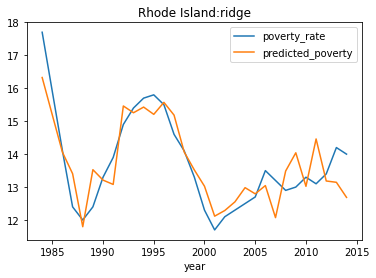

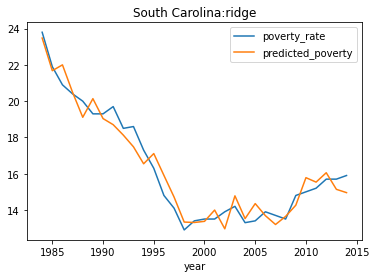

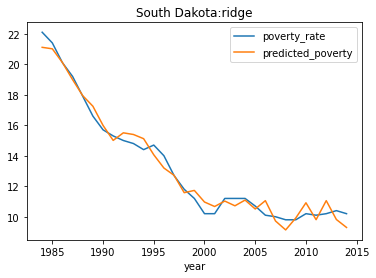

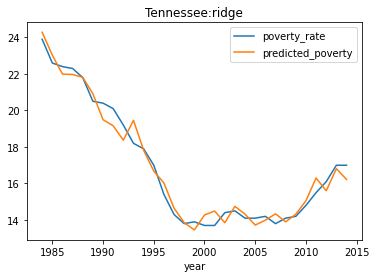

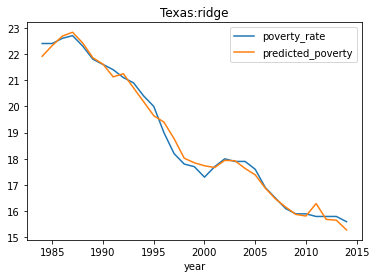

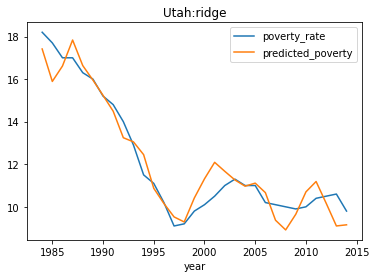

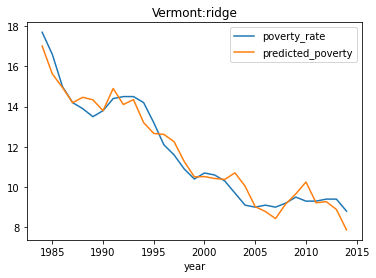

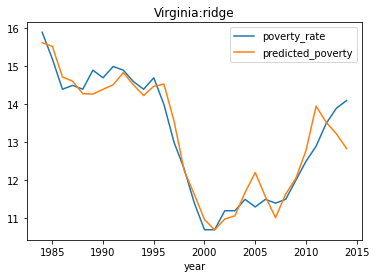

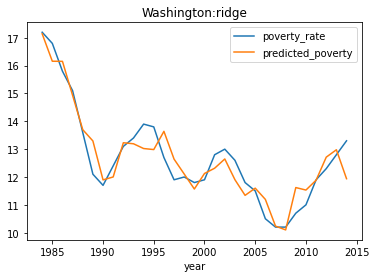

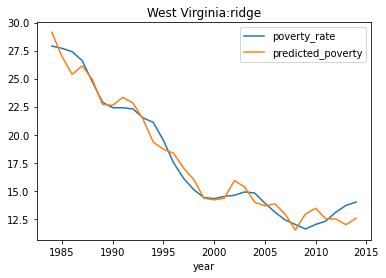

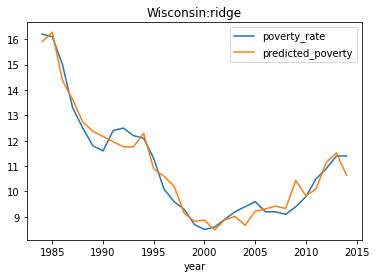

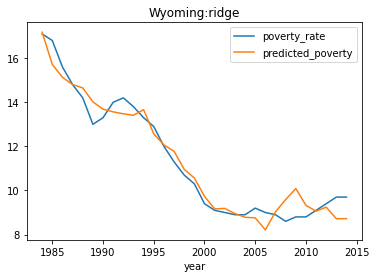

In [105]:
for state in model_df.state.unique():
    result = run_model(model_df, state, 'ridge')
    result_df = result_df.append(result, ignore_index=True)

C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.966868531703238, tolerance: 0.5031109999999999
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.399606251242945, tolerance: 6.371393548387097
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.73850573932328, tolerance: 2.6330733548387095
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the n

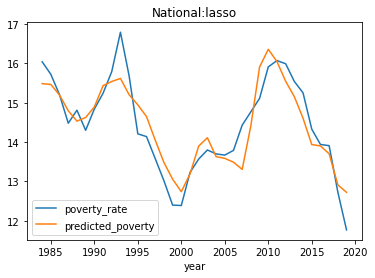

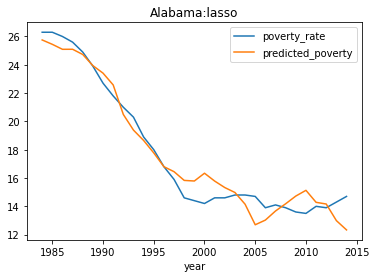

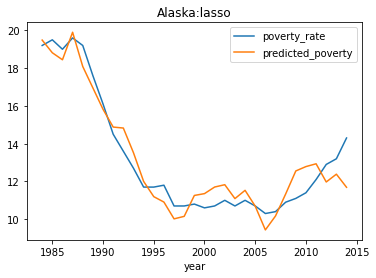

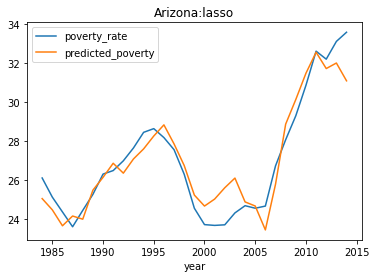

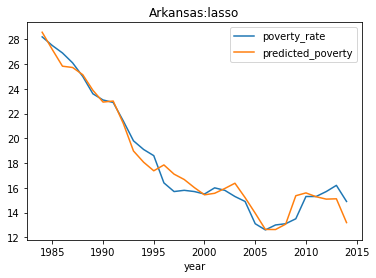

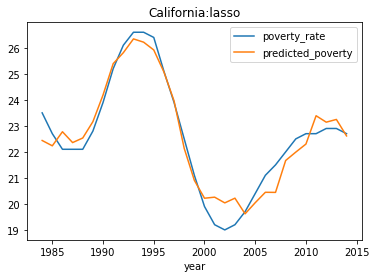

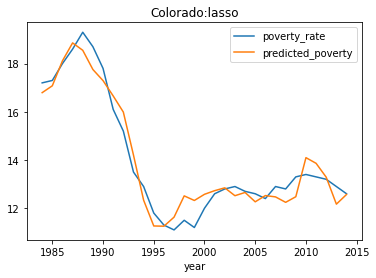

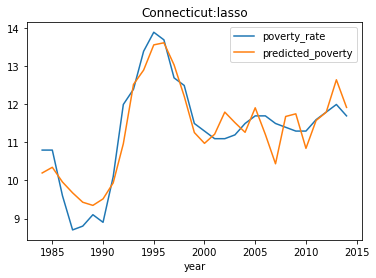

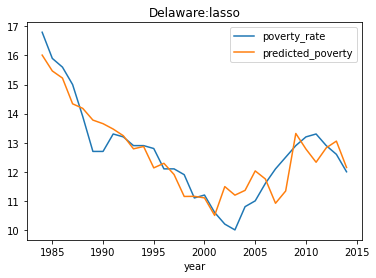

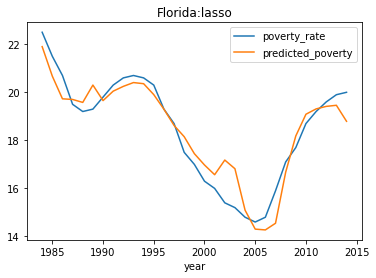

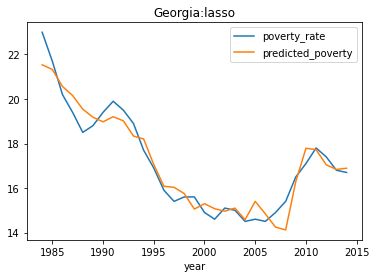

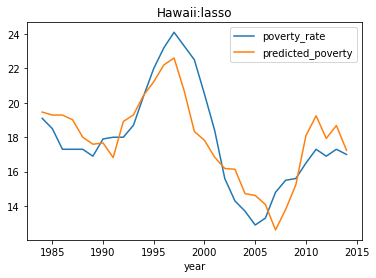

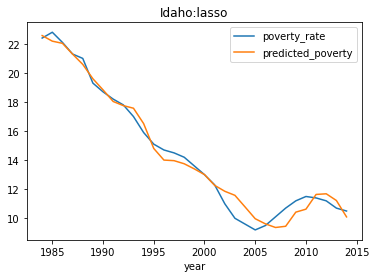

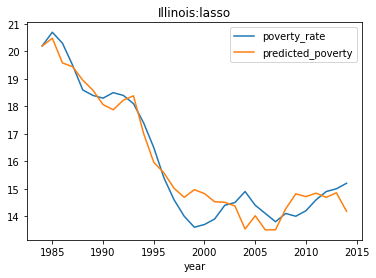

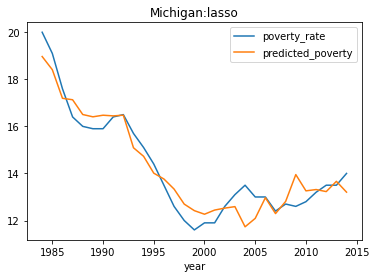

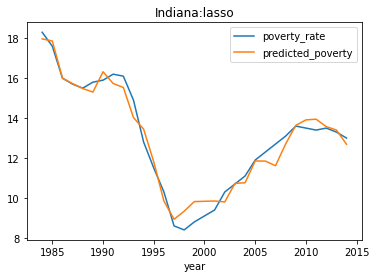

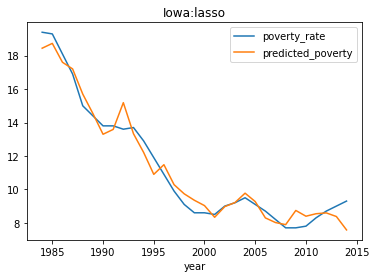

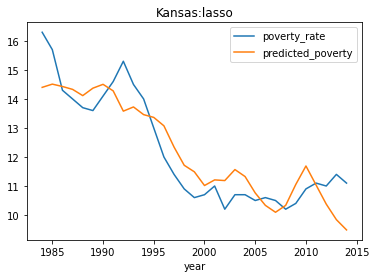

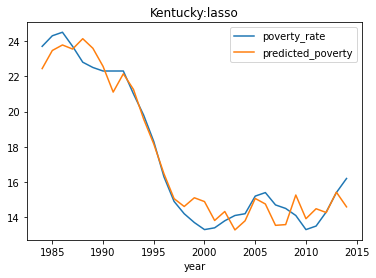

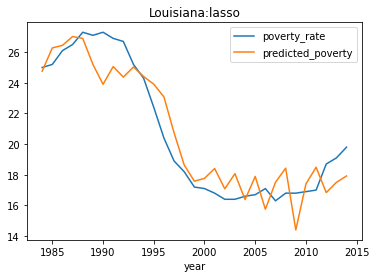

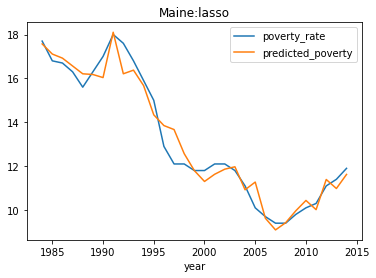

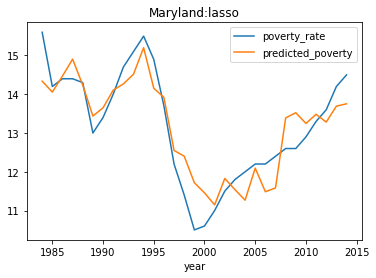

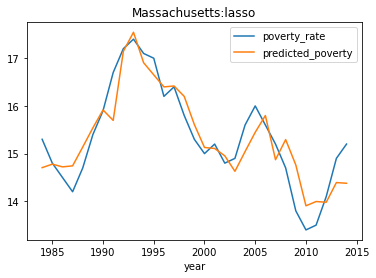

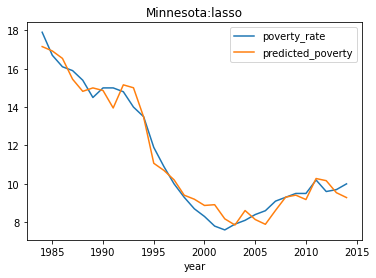

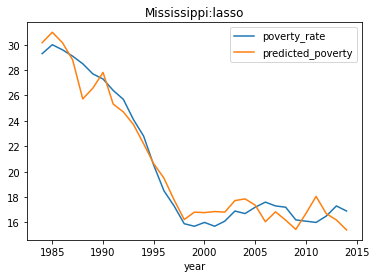

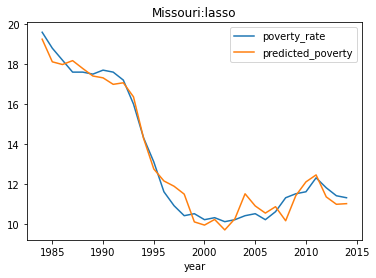

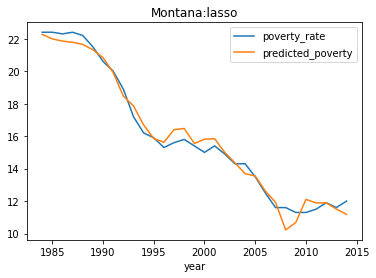

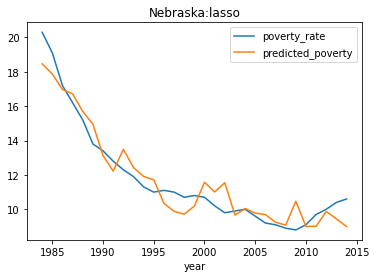

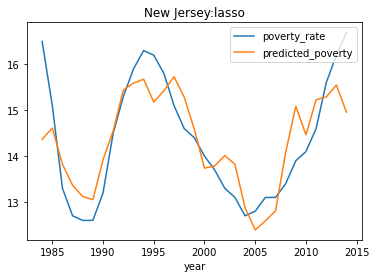

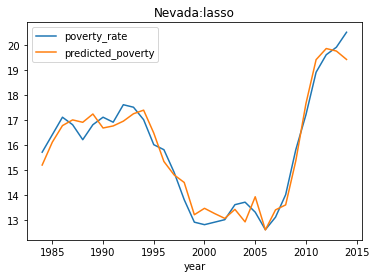

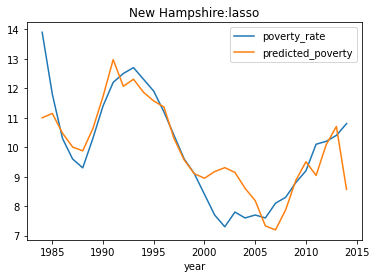

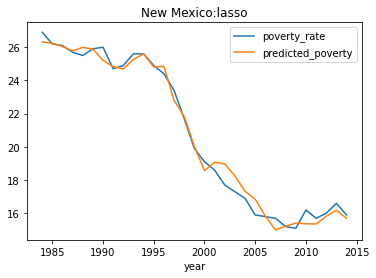

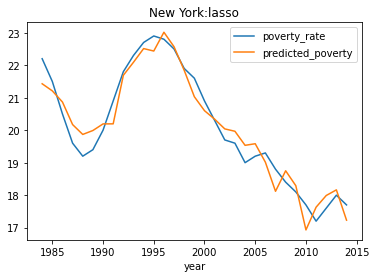

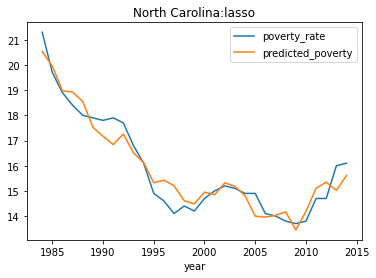

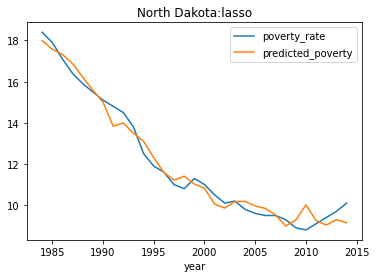

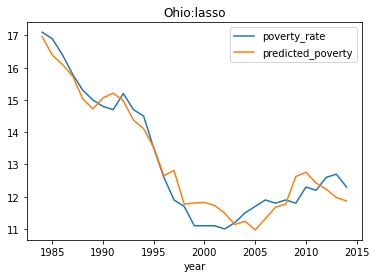

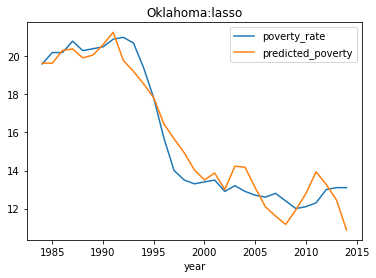

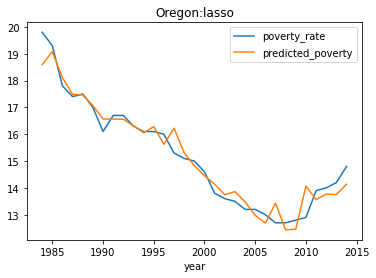

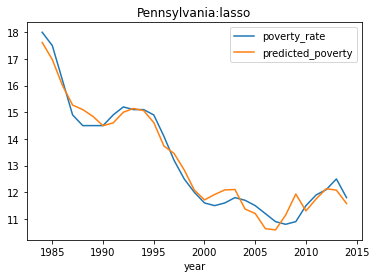

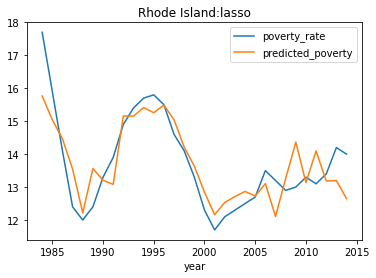

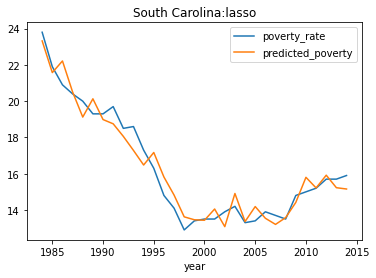

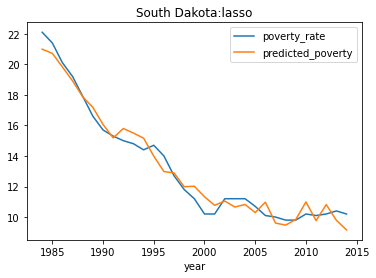

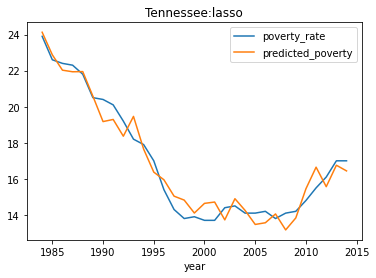

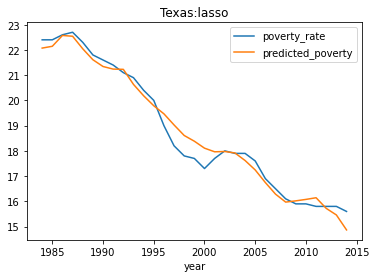

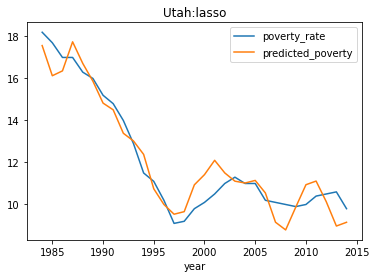

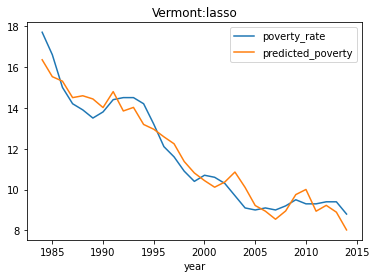

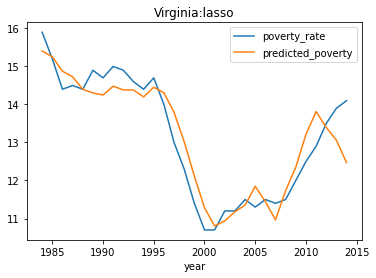

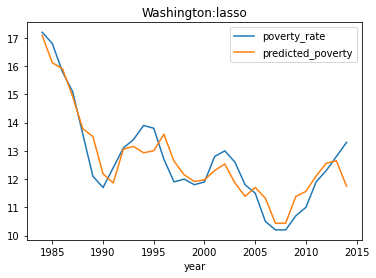

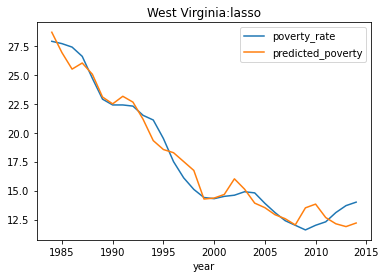

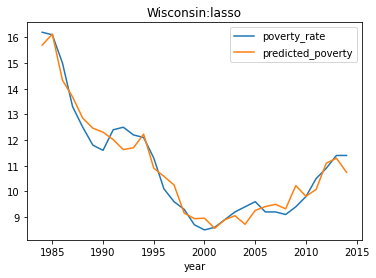

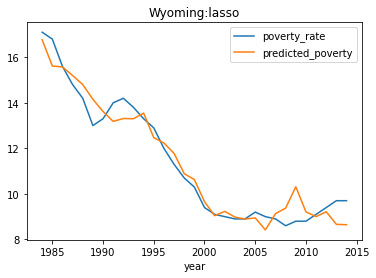

In [116]:
for state in model_df.state.unique():
    result = run_model(model_df, state, 'lasso')
 #   result_df = result_df.append(result, ignore_index=True)

In [111]:
result_df

,Coefficients,Intercept,Mean absolute error,Mean square error,Model,State,r2 score
0,"[0.05295144296555982, -0.0034517074658968077, ...",11.361216,0.241861,0.102481,linear,National,0.926670
1,"[-58.3884902387106, -0.009144964893661001, 0.7...",247.951691,0.472670,0.395948,linear,Alabama,0.980735
2,"[-81.39466861453498, -0.016565636646492823, -0...",95.629659,0.630713,0.574746,linear,Alaska,0.942107
3,"[-7.09014159294931, -0.017520041701752496, -0....",-11.714009,0.568094,0.469507,linear,Arizona,0.944724
4,"[-33.24335566230203, -0.017339856349392307, 1....",65.314915,0.543251,0.447990,linear,Arkansas,0.979841
...,...,...,...,...,...,...,...
97,"[-0.28759604319467047, -0.013439852482747917, ...",37.285768,0.326934,0.199191,ridge,Virginia,0.919710
98,"[0.09928325919403362, -0.010883399603200146, 0...",18.736020,0.442852,0.322322,ridge,Washington,0.886879
99,"[0.30949970531276216, -0.019985815875458213, 1...",43.635603,0.758015,0.862635,ridge,West Virginia,0.968964
100,"[-0.01624454744214798, -0.007379347647257937, ...",31.726989,0.364923,0.191864,ridge,Wisconsin,0.955711


In [208]:
result3_df = pd.DataFrame()
result3_df = result_df[result_df.Model=='linear'].copy()
result3_df.dtypes
r2_linear = result3_df['r2 score'].tolist()
r2_ridge = result_df.loc[result_df.Model=='ridge']['r2 score'].tolist()
result3_df['r2 score ridge']=r2_ridge
result3_df['delta r2']=result3_df['r2 score']-result3_df['r2 score ridge']
result3_df= result3_df.set_index('State').sort_values(by='delta r2', ascending=True)
result3_df

,Coefficients,Intercept,Mean absolute error,Mean square error,Model,r2 score,r2 score ridge,delta r2
State,,,,,,,,
New York,"[1.4448192536230353, -0.0015300046649025128, 0...",-8.645365,0.295289,0.118196,linear,0.960396,0.959001,0.001396
Maryland,"[0.08478798405614438, -0.008792100417834941, 0...",37.802267,0.410295,0.260327,linear,0.868953,0.867317,0.001636
Wisconsin,"[-1.5163139820367828, -0.00476654425183376, 0....",57.974670,0.357597,0.183629,linear,0.957611,0.955711,0.001901
Texas,"[1.8730086012655096, 0.002380326814155882, 0.4...",17.533844,0.167460,0.047168,linear,0.992102,0.990029,0.002073
Kentucky,"[17.343514016966573, 0.012609415714755927, 1.1...",-18.653181,0.528293,0.455232,linear,0.972039,0.969915,0.002124
New Mexico,"[1.3451177842280744, 0.003965929653582368, 0.3...",7.648327,0.275538,0.106956,linear,0.994523,0.992380,0.002143
California,"[-2.0441742333608093, 0.00809222821392503, 0.2...",30.055437,0.298705,0.137329,linear,0.969505,0.967358,0.002147
Maine,"[44.11837098329902, -0.035482196053207, 0.8429...",-4.960916,0.364110,0.244797,linear,0.970308,0.967991,0.002316
Indiana,"[-7.310511118416926, -0.004693265724810871, 1....",72.506523,0.257169,0.109738,linear,0.984981,0.982593,0.002388


In [18]:
result3_df.plot(y='r2 score',kind='barh',use_index=True, figsize=(5,20))

NameError: name 'result3_df' is not defined